In [ ]:
# load pandas and read the csv file from the url
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# I don't know why it takes so long to load the data
# df = pd.read_csv("https://github.com/krsoy/AAU_Projects/blob/Bitian/survey_results_public.csv")
df = pd.read_csv("https://media.githubusercontent.com/media/krsoy/AAU_Projects/refs/heads/Bitian/survey_results_public.csv")

def basic_info(column):
    print(df[column].head())
    print('-'*40)
    print(df[column].tail())
    print('-'*40)
    print(df[column].isnull().sum())
    print('-'*40)
    print(df[column].value_counts())
    print('-'*40)
    print('*'*40)

# create a value mapping for all categorical data
value_maps = {}
def map_and_fill(column, fill_value=0):
    value_map = {v: i for i, v in enumerate(df[column].dropna().unique())}
    df[column] = df[column].map(value_map)
    df[column] = df[column].fillna(fill_value)
    value_maps[column] = value_map
    return value_map

def reverse_map_and_fill(column):
    if column in value_maps:
        _reverse_map = {v: k for k, v in value_maps[column].items()}
        df[column] = df[column].map(_reverse_map)
    else:
        print(f"No mapping found for column: {column}")

def bin_distribution(column, bins=10,rotate=0):
    plt.figure(figsize=(12,6))
    sns.histplot(df[column], bins=bins, kde=False)
    plt.title(f'{column} Distribution')
    plt.xlabel(column)
    plt.ylabel('Count')
    # rotate x labels
    if rotate:
        plt.xticks(rotation=rotate)
    plt.show()
# let's take a look at the data
print(df.head())
print(df.describe())
print(df.info())

   ResponseId                      MainBranch                 Age  \
0           1  I am a developer by profession  Under 18 years old   
1           2  I am a developer by profession     35-44 years old   
2           3  I am a developer by profession     45-54 years old   
3           4           I am learning to code     18-24 years old   
4           5  I am a developer by profession     18-24 years old   

            Employment RemoteWork   Check  \
0  Employed, full-time     Remote  Apples   
1  Employed, full-time     Remote  Apples   
2  Employed, full-time     Remote  Apples   
3   Student, full-time        NaN  Apples   
4   Student, full-time        NaN  Apples   

                                    CodingActivities  \
0                                              Hobby   
1  Hobby;Contribute to open-source projects;Other...   
2  Hobby;Contribute to open-source projects;Other...   
3                                                NaN   
4                                 

we can see null values throughout all columns, few columns have filled with  full values.

now we will look into the data and see what we can do to clean it up and make it ready for analysis.

In [7]:
# start checking..
basic_info("ResponseId")

# so response_id can be used as index
df.set_index('ResponseId', inplace=True) # setting index

0    1
1    2
2    3
3    4
4    5
Name: ResponseId, dtype: int64
----------------------------------------
65432    65433
65433    65434
65434    65435
65435    65436
65436    65437
Name: ResponseId, dtype: int64
----------------------------------------
0
----------------------------------------
ResponseId
1        1
43631    1
43618    1
43619    1
43620    1
        ..
21818    1
21819    1
21820    1
21821    1
65437    1
Name: count, Length: 65437, dtype: int64
----------------------------------------
****************************************


In [8]:
# start checking..
basic_info("MainBranch")

# main_branch seems like a categorical data, asssign the unique values to the value_maps map to interger

print(map_and_fill("MainBranch"))


ResponseId
1    I am a developer by profession
2    I am a developer by profession
3    I am a developer by profession
4             I am learning to code
5    I am a developer by profession
Name: MainBranch, dtype: object
----------------------------------------
ResponseId
65433    I am a developer by profession
65434    I am a developer by profession
65435    I am a developer by profession
65436    I am a developer by profession
65437       I code primarily as a hobby
Name: MainBranch, dtype: object
----------------------------------------
0
----------------------------------------
MainBranch
I am a developer by profession                                                           50207
I am not primarily a developer, but I write code sometimes as part of my work/studies     6511
I am learning to code                                                                     3875
I code primarily as a hobby                                                               3334
I used to be a dev

In [9]:
# it seems like a categorical data, let's see the unique values
print(df['MainBranch'].value_counts())
# ok, its categorical data

MainBranch
0    50207
3     6511
1     3875
2     3334
4     1510
Name: count, dtype: int64


In [10]:
basic_info("Age")
# 0 null values

# mapping the age column
print(map_and_fill("Age"))

ResponseId
1    Under 18 years old
2       35-44 years old
3       45-54 years old
4       18-24 years old
5       18-24 years old
Name: Age, dtype: object
----------------------------------------
ResponseId
65433    18-24 years old
65434    25-34 years old
65435    25-34 years old
65436    18-24 years old
65437    18-24 years old
Name: Age, dtype: object
----------------------------------------
0
----------------------------------------
Age
25-34 years old       23911
35-44 years old       14942
18-24 years old       14098
45-54 years old        6249
55-64 years old        2575
Under 18 years old     2568
65 years or older       772
Prefer not to say       322
Name: count, dtype: int64
----------------------------------------
****************************************
{'Under 18 years old': 0, '35-44 years old': 1, '45-54 years old': 2, '18-24 years old': 3, '25-34 years old': 4, '55-64 years old': 5, 'Prefer not to say': 6, '65 years or older': 7}


age is categorical data, we can keep it as it is. But I assume it represented register age/ working experience, not the actual age of the respondents

In [11]:
basic_info("RemoteWork")
# mapping the remote_work column
print(map_and_fill("RemoteWork"))

df['RemoteWork'] = df['RemoteWork'].fillna(0)# filling null values with 0
print(df['RemoteWork'].value_counts())

ResponseId
1    Remote
2    Remote
3    Remote
4       NaN
5       NaN
Name: RemoteWork, dtype: object
----------------------------------------
ResponseId
65433                                  Remote
65434                                  Remote
65435                               In-person
65436    Hybrid (some remote, some in-person)
65437                                     NaN
Name: RemoteWork, dtype: object
----------------------------------------
10631
----------------------------------------
RemoteWork
Hybrid (some remote, some in-person)    23015
Remote                                  20831
In-person                               10960
Name: count, dtype: int64
----------------------------------------
****************************************
{'Remote': 0, 'In-person': 1, 'Hybrid (some remote, some in-person)': 2}
RemoteWork
0.0    31462
2.0    23015
1.0    10960
Name: count, dtype: int64


remote_work is categorical data, we can keep it as it is. And fill the null values with 0, meaning no remote work/experience

In [12]:
basic_info("EdLevel")
# don't know what it is yet, but it seems categorical data, filling null with 0
print(map_and_fill("EdLevel"))
df['EdLevel'] = df['EdLevel'].fillna(0)

ResponseId
1                            Primary/elementary school
2         Bachelor’s degree (B.A., B.S., B.Eng., etc.)
3      Master’s degree (M.A., M.S., M.Eng., MBA, etc.)
4    Some college/university study without earning ...
5    Secondary school (e.g. American high school, G...
Name: EdLevel, dtype: object
----------------------------------------
ResponseId
65433         Bachelor’s degree (B.A., B.S., B.Eng., etc.)
65434                                                  NaN
65435         Bachelor’s degree (B.A., B.S., B.Eng., etc.)
65436    Secondary school (e.g. American high school, G...
65437                                                  NaN
Name: EdLevel, dtype: object
----------------------------------------
4653
----------------------------------------
EdLevel
Bachelor’s degree (B.A., B.S., B.Eng., etc.)                                          24942
Master’s degree (M.A., M.S., M.Eng., MBA, etc.)                                       15557
Some college/university study 

In [13]:
basic_info("Check")
# only 1 value drop this column
df.drop(columns=['Check'], inplace=True)

ResponseId
1    Apples
2    Apples
3    Apples
4    Apples
5    Apples
Name: Check, dtype: object
----------------------------------------
ResponseId
65433    Apples
65434    Apples
65435    Apples
65436    Apples
65437    Apples
Name: Check, dtype: object
----------------------------------------
0
----------------------------------------
Check
Apples    65437
Name: count, dtype: int64
----------------------------------------
****************************************


In [14]:
# CodingActivities
basic_info("CodingActivities")
#TODO expand

ResponseId
1                                                Hobby
2    Hobby;Contribute to open-source projects;Other...
3    Hobby;Contribute to open-source projects;Other...
4                                                  NaN
5                                                  NaN
Name: CodingActivities, dtype: object
----------------------------------------
ResponseId
65433                        Hobby;School or academic work
65434             Hobby;Contribute to open-source projects
65435                                                Hobby
65436    Hobby;Contribute to open-source projects;Profe...
65437                                                  NaN
Name: CodingActivities, dtype: object
----------------------------------------
10971
----------------------------------------
CodingActivities
Hobby                                                                                                                                                                              9993
I 

ResponseId
1    Employed, full-time
2    Employed, full-time
3    Employed, full-time
4     Student, full-time
5     Student, full-time
Name: Employment, dtype: object
----------------------------------------
ResponseId
65433    Employed, full-time
65434    Employed, full-time
65435    Employed, full-time
65436    Employed, full-time
65437     Student, full-time
Name: Employment, dtype: object
----------------------------------------
0
----------------------------------------
Employment
Employed, full-time                                                                                                                                  39041
Independent contractor, freelancer, or self-employed                                                                                                  4846
Student, full-time                                                                                                                                    4709
Employed, full-time;Independent contractor,

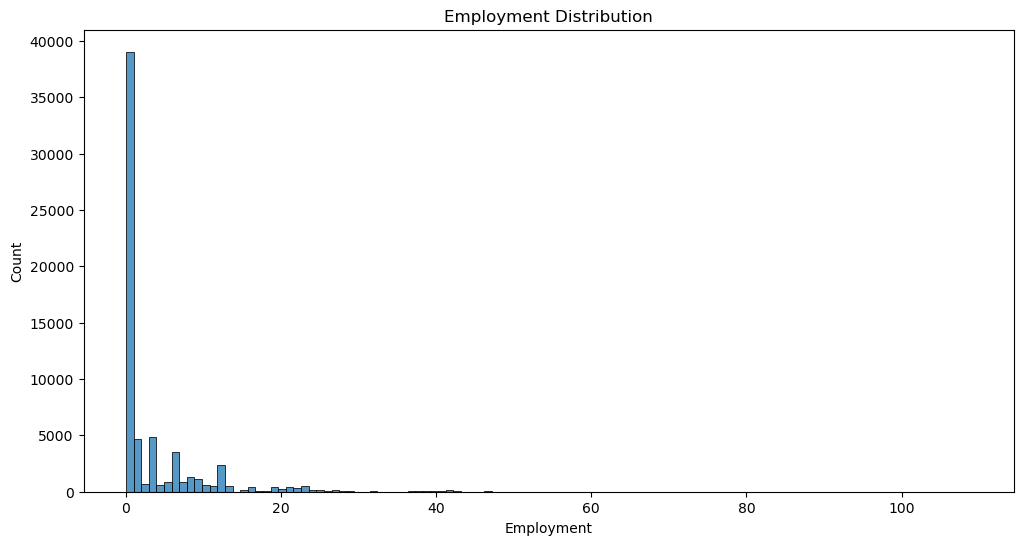

In [15]:
basic_info("Employment")


# mapping the Employment column
print(map_and_fill("Employment"))
df['Employment'] = df['Employment'].fillna(0)
# plot distribution of Employment column

bin_distribution("Employment", bins=len(df['Employment'].unique())+1)



In [16]:
# categorical data, a lot null values
#TODO need to expand
basic_info('LearnCode')
basic_info('CodingActivities')
basic_info('LearnCodeOnline')
basic_info('TechDoc')


ResponseId
1                               Books / Physical media
2    Books / Physical media;Colleague;On the job tr...
3    Books / Physical media;Colleague;On the job tr...
4    Other online resources (e.g., videos, blogs, f...
5    Other online resources (e.g., videos, blogs, f...
Name: LearnCode, dtype: object
----------------------------------------
ResponseId
65433    On the job training;School (i.e., University, ...
65434                                                  NaN
65435    Other online resources (e.g., videos, blogs, f...
65436    On the job training;Other online resources (e....
65437                                                  NaN
Name: LearnCode, dtype: object
----------------------------------------
4949
----------------------------------------
LearnCode
Other online resources (e.g., videos, blogs, forum, online community)                                                                                                 3674
Books / Physical media;Other online r

ResponseId
1    NaN
2     20
3     37
4      4
5      9
Name: YearsCode, dtype: object
----------------------------------------
ResponseId
65433      5
65434    NaN
65435      9
65436      5
65437    NaN
Name: YearsCode, dtype: object
----------------------------------------
5568
----------------------------------------
YearsCode
10                    4561
5                     3723
6                     3496
8                     3449
7                     3333
4                     3290
15                    2813
20                    2636
12                    2559
3                     2518
9                     2251
14                    1822
25                    1671
2                     1642
11                    1636
13                    1477
30                    1461
16                    1401
18                    1228
17                    1038
40                     993
24                     870
22                     842
35                     735
1                   

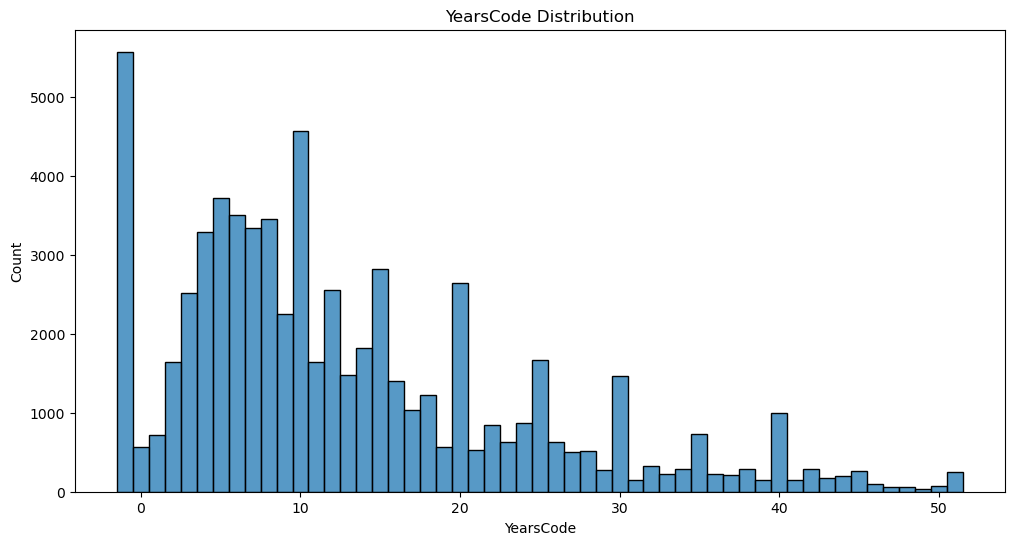

In [17]:
basic_info('YearsCode')
# 2 unique string values 'Less than 1 year' and 'More than 50 years'
# convert them to 0 and 51
df['YearsCode'] = df['YearsCode'].replace({'Less than 1 year': 0, 'More than 50 years': 51})
basic_info("YearsCode")
# need to handle the null values
df['YearsCode'] = df['YearsCode'].fillna(-1)
bin_distribution('YearsCode', bins=52)

ResponseId
1    NaN
2     17
3     27
4    NaN
5    NaN
Name: YearsCodePro, dtype: object
----------------------------------------
ResponseId
65433      3
65434    NaN
65435      5
65436      2
65437    NaN
Name: YearsCodePro, dtype: object
----------------------------------------
13827
----------------------------------------
YearsCodePro
2                     4168
3                     4093
5                     3526
10                    3251
4                     3215
Less than 1 year      2856
6                     2843
1                     2639
8                     2549
7                     2517
12                    1777
15                    1635
20                    1549
9                     1493
11                    1312
13                    1127
14                    1082
25                     998
16                     946
18                     867
17                     814
30                     689
24                     632
19                     516
22        

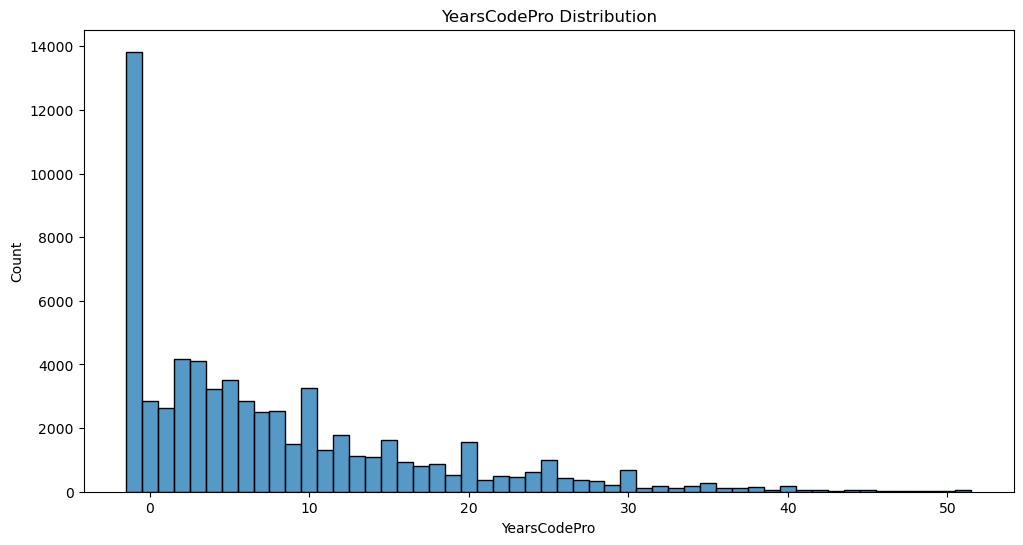

In [18]:
basic_info('YearsCodePro')
df['YearsCodePro'] = df['YearsCodePro'].replace({'Less than 1 year': 0, 'More than 50 years': 51})
basic_info("YearsCodePro")
# need to handle the null values
df['YearsCodePro'] = df['YearsCodePro'].fillna(-1)

bin_distribution('YearsCodePro', bins=52)

ResponseId
1                      NaN
2    Developer, full-stack
3     Developer Experience
4    Developer, full-stack
5    Developer, full-stack
Name: DevType, dtype: object
----------------------------------------
ResponseId
65433             Blockchain
65434                    NaN
65435      Developer, mobile
65436    Developer, back-end
65437                    NaN
Name: DevType, dtype: object
----------------------------------------
5992
----------------------------------------
DevType
Developer, full-stack                            18260
Developer, back-end                               9928
Student                                           5102
Developer, front-end                              3349
Developer, desktop or enterprise applications     2493
Other (please specify):                           2458
Developer, mobile                                 2021
Developer, embedded applications or devices       1623
Engineering manager                               1275
Academic 

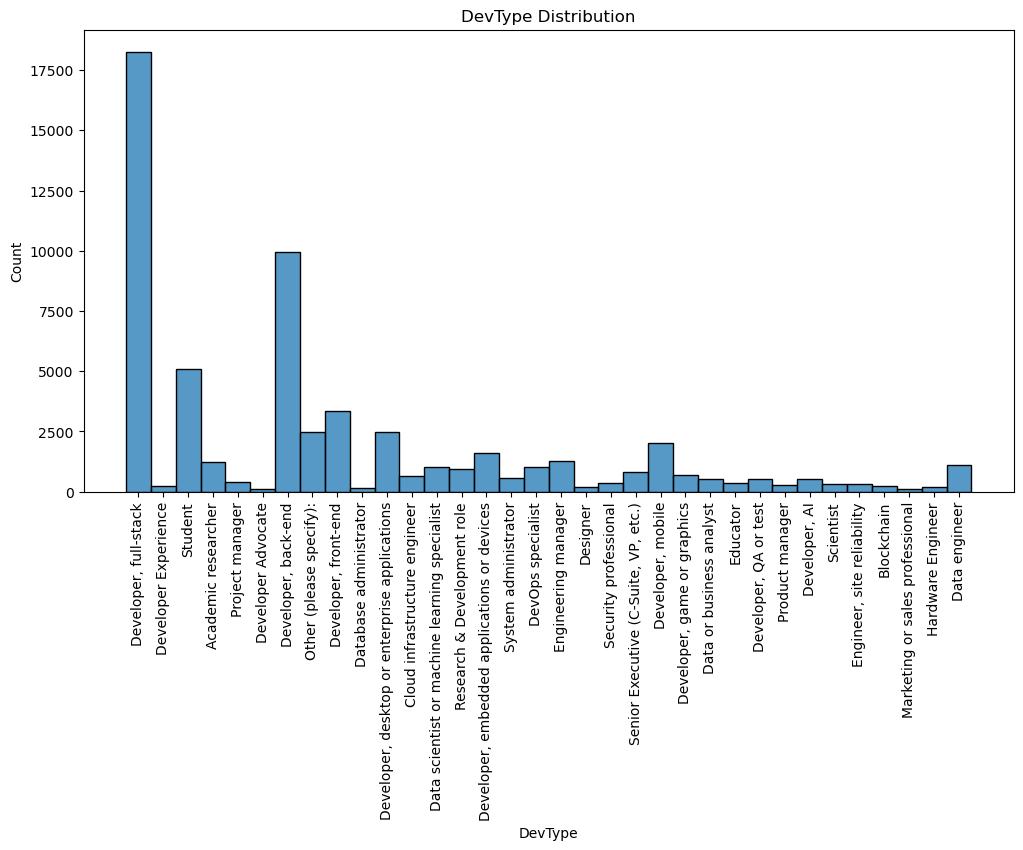

{'Developer, full-stack': 0, 'Developer Experience': 1, 'Student': 2, 'Academic researcher': 3, 'Project manager': 4, 'Developer Advocate': 5, 'Developer, back-end': 6, 'Other (please specify):': 7, 'Developer, front-end': 8, 'Database administrator': 9, 'Developer, desktop or enterprise applications': 10, 'Cloud infrastructure engineer': 11, 'Data scientist or machine learning specialist': 12, 'Research & Development role': 13, 'Developer, embedded applications or devices': 14, 'System administrator': 15, 'DevOps specialist': 16, 'Engineering manager': 17, 'Designer': 18, 'Security professional': 19, 'Senior Executive (C-Suite, VP, etc.)': 20, 'Developer, mobile': 21, 'Developer, game or graphics': 22, 'Data or business analyst': 23, 'Educator': 24, 'Developer, QA or test': 25, 'Product manager': 26, 'Developer, AI': 27, 'Scientist': 28, 'Engineer, site reliability': 29, 'Blockchain': 30, 'Marketing or sales professional': 31, 'Hardware Engineer': 32, 'Data engineer': 33}


In [19]:
basic_info("DevType")
bin_distribution('DevType', bins=df['DevType'].nunique()+1,rotate=90)
print(map_and_fill("DevType"))
df['DevType'] = df['DevType'].fillna(-1)




ResponseId
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
Name: OrgSize, dtype: object
----------------------------------------
ResponseId
65433            2 to 9 employees
65434                         NaN
65435    1,000 to 4,999 employees
65436          20 to 99 employees
65437                         NaN
Name: OrgSize, dtype: object
----------------------------------------
17957
----------------------------------------
OrgSize
20 to 99 employees                                    9754
100 to 499 employees                                  8694
10,000 or more employees                              5558
1,000 to 4,999 employees                              5353
2 to 9 employees                                      4833
10 to 19 employees                                    4084
500 to 999 employees                                  3183
Just me - I am a freelancer, sole proprietor, etc.    3086
5,000 to 9,999 employees                              1867
I don’t know                         

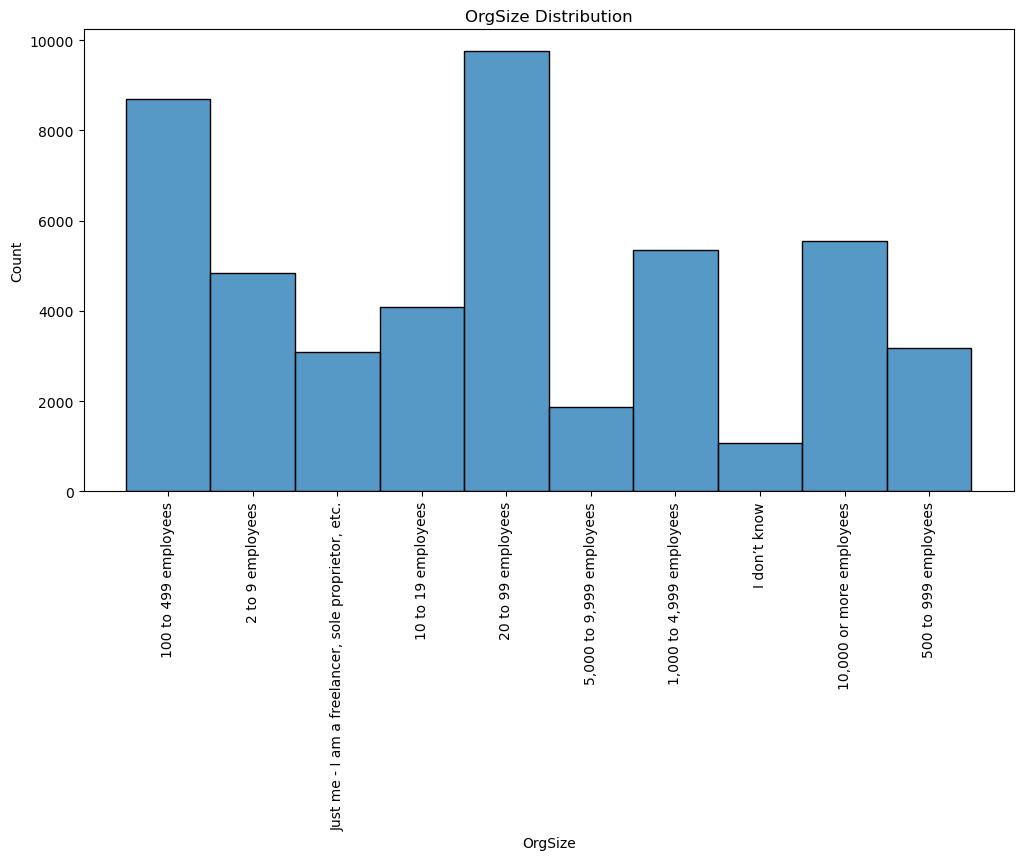

{'100 to 499 employees': 0, '2 to 9 employees': 1, 'Just me - I am a freelancer, sole proprietor, etc.': 2, '10 to 19 employees': 3, '20 to 99 employees': 4, '5,000 to 9,999 employees': 5, '1,000 to 4,999 employees': 6, 'I don’t know': 7, '10,000 or more employees': 8, '500 to 999 employees': 9}


In [20]:
basic_info("OrgSize")
bin_distribution('OrgSize', bins=df['OrgSize'].nunique()+1,rotate=90)
# categorical data, a lot null values, fill null with -1 meaning no response/don't have an organization?
print(map_and_fill("OrgSize"))
df['OrgSize'] = df['OrgSize'].fillna(-1)




In [21]:
basic_info("PurchaseInfluence")
# categorical data, a lot null values, fill null with -1 meaning no response/don't have an influence
print(map_and_fill("PurchaseInfluence"))
df['PurchaseInfluence'] = df['PurchaseInfluence'].fillna(-1)


ResponseId
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
Name: PurchaseInfluence, dtype: object
----------------------------------------
ResponseId
65433            I have some influence
65434                              NaN
65435    I have little or no influence
65436            I have some influence
65437                              NaN
Name: PurchaseInfluence, dtype: object
----------------------------------------
18031
----------------------------------------
PurchaseInfluence
I have some influence               19197
I have little or no influence       17942
I have a great deal of influence    10267
Name: count, dtype: int64
----------------------------------------
****************************************
{'I have some influence': 0, 'I have little or no influence': 1, 'I have a great deal of influence': 2}


In [22]:
#TODO here
basic_info("BuyNewTool")# another need to expand categorial data

basic_info('BuildvsBuy')
# don't plot this for the name is so long
# mapping the BuildvsBuy column
print(map_and_fill("BuildvsBuy"))
# filling null values with -1, meaning?
#TODO meaning?
df['BuildvsBuy'] = df['BuildvsBuy'].fillna(-1)



ResponseId
1    NaN
2    NaN
3    NaN
4    NaN
5    NaN
Name: BuyNewTool, dtype: object
----------------------------------------
ResponseId
65433    Ask developers I know/work with;Ask a generati...
65434                                                  NaN
65435    Ask developers I know/work with;Ask a generati...
65436    Start a free trial;Ask developers I know/work ...
65437                                                  NaN
Name: BuyNewTool, dtype: object
----------------------------------------
20256
----------------------------------------
BuyNewTool
Start a free trial;Ask developers I know/work with;Visit developer communities like Stack Overflow                                                               6619
Start a free trial;Ask developers I know/work with                                                                                                               4927
Start a free trial;Ask developers I know/work with;Visit developer communities like Stack Overflow;Rea

In [23]:
# 查看包含 salary / compensation 的列
salary_cols = [col for col in df.columns if "Comp" in col or "Salary" in col or "Pay" in col]
print(salary_cols)

['CompTotal', 'AIComplex', 'ConvertedCompYearly']
